<a href="https://colab.research.google.com/github/jfriisKU/6g/blob/master/EMLA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import torch

SEED = 42
import pandas as pd
import numpy as np

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from torch.utils.data import TensorDataset, DataLoader

import os

import random
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from PIL import Image
#skimage.io.imread
#from skimage.external.tifffile import imread
from torchvision.transforms import ToTensor

from skimage.io import imread, imshow
from skimage.color import rgb2gray

import matplotlib.pyplot as plt


In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
train_dir_in = '/content/drive/My Drive/EML/Images_train'
label_dir_in = '/content/drive/My Drive/EML/Labels_train'
test_dir_in = '/content/drive/My Drive/EML/Images_test'

In [85]:
os.listdir(train_dir_in)

['2_training.tif',
 '10_training.tif',
 '9_training.tif',
 '4_training.tif',
 '6_training.tif',
 '3_training.tif',
 '5_training.tif',
 '8_training.tif',
 '1_training.tif',
 '14_training.tif',
 '7_training.tif',
 '12_training.tif',
 '11_training.tif',
 '15_training.tif',
 '13_training.tif']

In [86]:
def load_images_files_dir(path):
  files = [f for f in os.listdir(path)]
  #print(files)

  files.sort()
  print(files)
  images = []
  for f in files:
    img_path = path + '/' + f
    img = Image.open(img_path)
    img = np.asarray(img)
    images.append(img)

  return np.array(images)


In [87]:
train_imgs = load_images_files_dir(train_dir_in)
labels_imgs = load_images_files_dir(label_dir_in)
#print(labels_imgs[0][200:400,200:400])
labels_imgs = labels_imgs//255.0 # Transform them to 0 .. 1
#labels_imgs = labels_imgs//255 # Transform them to 0 .. 1
test_imgs = load_images_files_dir(test_dir_in)

['10_training.tif', '11_training.tif', '12_training.tif', '13_training.tif', '14_training.tif', '15_training.tif', '1_training.tif', '2_training.tif', '3_training.tif', '4_training.tif', '5_training.tif', '6_training.tif', '7_training.tif', '8_training.tif', '9_training.tif']
['10_manual1.gif', '11_manual1.gif', '12_manual1.gif', '13_manual1.gif', '14_manual1.gif', '15_manual1.gif', '1_manual1.gif', '2_manual1.gif', '3_manual1.gif', '4_manual1.gif', '5_manual1.gif', '6_manual1.gif', '7_manual1.gif', '8_manual1.gif', '9_manual1.gif']
['1_test.tif', '2_test.tif', '3_test.tif', '4_test.tif', '5_test.tif']


In [88]:
#image = Image.open('/path/to/image.tif')
#image = ToTensor()(image)

In [89]:
print(f'We have {len(train_imgs)} training images of shape = {train_imgs[0].shape}')
print(f'Training image has shape = {train_imgs[0].shape}')
print(f'Labels has shape {labels_imgs[0].shape}')
print(f'We have {len(test_imgs)} test images of shape = {test_imgs[0].shape}')

We have 15 training images of shape = (584, 565, 3)
Training image has shape = (584, 565, 3)
Labels has shape (584, 565)
We have 5 test images of shape = (584, 565, 3)


In [90]:
#train_red_channel = train_imgs[:,:,:,0]/128.0 -1 
train_green_channel = train_imgs[:,:,:,1]/255
#train_blue_channel = train_imgs[:,:,:,2]/128.0 -1 
train_grayscales = rgb2gray(train_imgs)

In [91]:

print(train_green_channel)
print(train_green_channel.shape)



[[[0.         0.         0.         ... 0.         0.00392157 0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.00392157 ... 0.         0.00392157 0.        ]
  ...
  [0.03137255 0.03137255 0.02745098 ... 0.02745098 0.02745098 0.02745098]
  [0.02745098 0.03137255 0.03137255 ... 0.02745098 0.02352941 0.02352941]
  [0.01960784 0.01960784 0.01960784 ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.00392157]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.02745098 0.02745098 0.02352941 ... 0.03137255 0.01960784 0.02745098]
  [0.02352941 0.02352941 0.02352941 ... 0.03137255 0.02745098 0.03137255]
  [0.02745098 0.02352941 0.02352941 ... 0.         0.         0.        ]]

 [[0.         0.         0.00392157 ... 0.         0.         0.        ]
  [0.         0.003921

In [92]:
test_imgs_green_channel = test_imgs[:,:,:,1]/255

In [93]:
img0_rgb = train_imgs[0,0,:]

In [94]:

"""
fig, ax = plt.subplots(1, 4, figsize = (18, 30))
ax[0].imshow(train_imgs[0]/255.0) 
ax[0].axis('off')
ax[0].set_title('original RGB')
ax[1].imshow(train_imgs[0,:,:,0]/255.0) 
ax[1].axis('off')
ax[1].set_title('original RGB')
ax[2].imshow(train_imgs[0,:,:,1]/255.0) 
ax[2].axis('off')
ax[2].set_title('original RGB')
ax[3].imshow(train_imgs[0,:,:,2]/255.0) 
ax[3].axis('off')
ax[3].set_title('original RGB')
plt.show()
"""

"\nfig, ax = plt.subplots(1, 4, figsize = (18, 30))\nax[0].imshow(train_imgs[0]/255.0) \nax[0].axis('off')\nax[0].set_title('original RGB')\nax[1].imshow(train_imgs[0,:,:,0]/255.0) \nax[1].axis('off')\nax[1].set_title('original RGB')\nax[2].imshow(train_imgs[0,:,:,1]/255.0) \nax[2].axis('off')\nax[2].set_title('original RGB')\nax[3].imshow(train_imgs[0,:,:,2]/255.0) \nax[3].axis('off')\nax[3].set_title('original RGB')\nplt.show()\n"

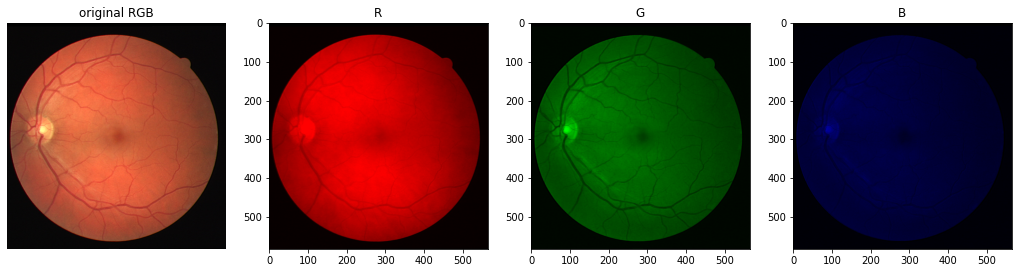

In [95]:
fig, ax = plt.subplots(1, 4, figsize = (18, 30))
ax[0].imshow(train_imgs[0]/255.0) 
ax[0].axis('off')
ax[0].set_title('original RGB')
for i, lab in enumerate(['R','G','B'], 1):
    temp = np.zeros(train_imgs[0].shape)
    temp[:,:,i - 1] = train_imgs[0][:,:,i - 1]
    ax[i].imshow(temp/255.0) 
    #ax[i].axis("off")
    ax[i].set_title(lab)
plt.show()

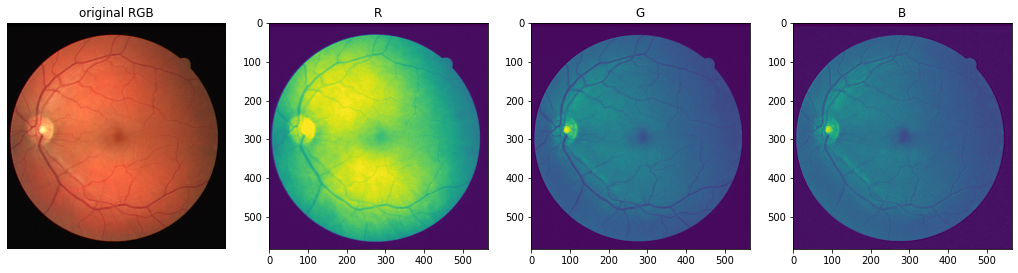

In [96]:
fig, ax = plt.subplots(1, 4, figsize = (18, 30))
ax[0].imshow(train_imgs[0]/255.0) 
ax[0].axis('off')
ax[0].set_title('original RGB')
ax[1].imshow(train_imgs[0,:,:,0]/255.0)
ax[1].set_title('R')
ax[2].imshow(train_imgs[0,:,:,1]/255.0) 
ax[2].set_title('G')
ax[3].imshow(train_imgs[0,:,:,2]/255.0) 
ax[3].set_title('B')
plt.show()

In [97]:
grayscale = rgb2gray(train_imgs[0])
print(grayscale.shape)

(584, 565)


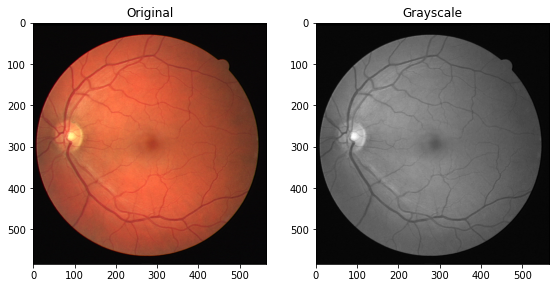

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(train_imgs[0])
ax[0].set_title("Original")
ax[1].imshow(grayscale, cmap=plt.cm.gray)
ax[1].set_title("Grayscale")

fig.tight_layout()
plt.show()

In [99]:
if torch.cuda.is_available():
    device = "cuda"
else: 
    device = "cpu"
    
print('device:',device)

device: cuda


In [100]:
VALIDATION_SET = 3
"""
x_train, x_valid, y_train, y_valid = train_test_split(train_grayscales, labels_imgs, test_size=VALIDATION_SET,
                                                    shuffle=True,random_state=42)
"""
x_train, x_valid, y_train, y_valid = train_test_split(train_grayscales, labels_imgs, test_size=VALIDATION_SET, shuffle=True,random_state=42)


print('Shape of traning data tensor:',x_train.shape)
print('Length of training label vector:',len(y_train))
print('Shape of validation data tensor:',x_valid.shape)
print('Length of validation label vector:',len(y_valid))
#print('Shape of test data tensor:',x_test.shape)
#print('Length of validation label vector:',len(y_test))

Shape of traning data tensor: (12, 584, 565)
Length of training label vector: 12
Shape of validation data tensor: (3, 584, 565)
Length of validation label vector: 3


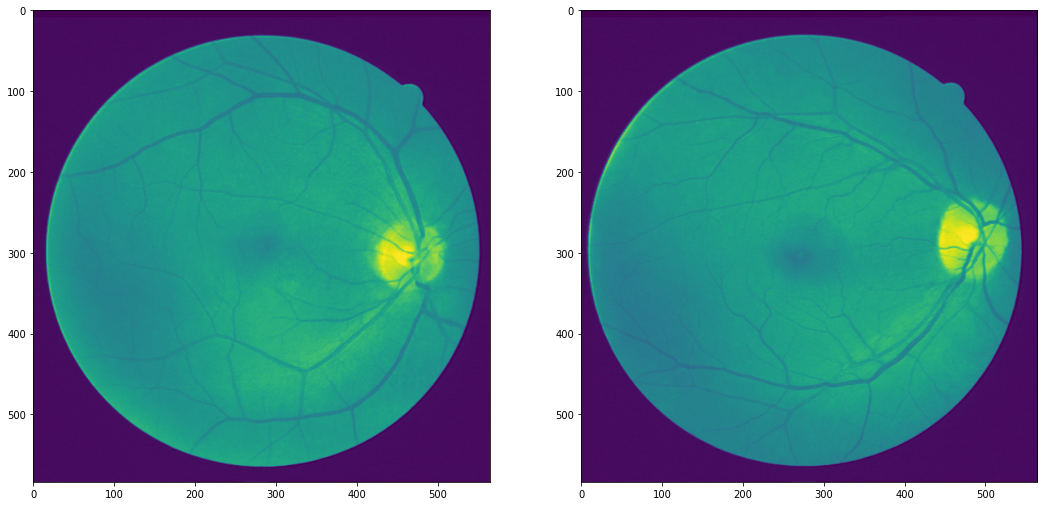

In [101]:
fig, ax = plt.subplots(1, 2, figsize = (18, 30))
ax[0].imshow(x_train[0]/255.0) 
ax[1].imshow(x_valid[0]) 
plt.show()

In [102]:
# Using pytouch data loaders

BATCH_SIZE = 13

print('Train: ',end="")
train_dataset = TensorDataset(torch.from_numpy(x_train).unsqueeze(1), torch.from_numpy(y_train).unsqueeze(1))

train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,
                         shuffle=True,num_workers=2)

print(len(train_loader),'images')

print('Validation: ',end="")
validation_dataset = TensorDataset(torch.from_numpy(x_valid).unsqueeze(1), torch.from_numpy(y_valid).unsqueeze(1))

validation_loader =DataLoader(validation_dataset,batch_size=VALIDATION_SET,
                         shuffle=True,num_workers=2)

print(len(validation_dataset),'images')


Train: 1 images
Validation: 3 images


In [103]:
len(train_loader)

1

In [104]:
#train_dataset

In [105]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = nn.ReLU()
        self.batchnor = nn.BatchNorm2d(out_ch, affine=False)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    
    def forward(self, x):
        return self.relu(self.batchnor(self.conv2(self.relu(self.batchnor(self.conv1(x))))))


class Encoder(nn.Module):
    def __init__(self, chs=(1,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(1,8,16,32,64,128), dec_chs=(128, 64, 32, 16, 8), num_class=1, retain_dim=True, out_sz=(584,565)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        out      = torch.sigmoid(out)
        if self.retain_dim:
            out = F.interpolate(out, (x.shape[2],x.shape[3]))
        return out


In [115]:
def train(model, train_loader, epoch):
    #Set model to train mode
    #model.train()
    epoch_loss = 0.
    for batch_idx, (data,target) in enumerate(train_loader):
        #Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)


        # Zero gradiant 
        optimizer.zero_grad()
        #Pass data throgh model
        output = model(data.float())
        #print('e')
        #print(output.shape)
        #Calculate loss
        loss = criterion(output,target.float())
        epoch_loss = epoch_loss + loss.item()
        
        print(f'Train loss.item() = {loss.item()}')
        #Backpropagate
        loss.backward()
        
        #update weights 
        optimizer.step()
        
        
    epoch_loss /= len(train_loader)
    #train_loss.append(epoch_loss)
    print('Train Epoch: {}, Loss: {:4f}'.format(epoch,epoch_loss))
    return epoch_loss

In [116]:
def evaluate(model, loader,epoch=None):

    # Set the model to evaluate mode
    #model.eval()
    loss = 0
    
    for data, target in loader:

        #print(data.shape)
        data = data.to(device)
        target = target.to(device)
        output = model(data.float())

        loss = criterion(output,target.float())
        print(f'Valdiation loss.item() = {loss.item()}')        
    
    #val_loss.append(loss)
    return loss.item()

In [108]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,pred, target):
        smooth = 1.
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        return 1-((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [ ]:
model = UNet().to(device)
#print(model)
optimizer = optim.Adam(model.parameters(),lr=0.01)
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
criterion = diceloss()
epochs = 100
train_loss_cross = []
val_loss_cross = []
for epoch in range(1,epochs+1):
    train_loss_cross.append(train(model, train_loader, epoch))
    with torch.no_grad():
        print('\nValidtionset:')
        val_loss_cross.append(evaluate(model, validation_loader, epoch))
""""""

In [ ]:
loss_plt(train_loss_cross,val_loss_cross)

In [109]:
model = UNet().to(device)
#print(model)
optimizer = optim.Adam(model.parameters(),lr=0.01)
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()
criterion = diceloss()
epochs = 100
train_loss_dice = []
val_loss_dice = []
for epoch in range(1,epochs+1):
    train_loss_dice.append(train(model, train_loader, epoch))
    with torch.no_grad():
        print('\nValidtionset:')
        val_loss_dice.append(evaluate(model, validation_loader, epoch))
""""""

Train loss.item() = 0.7657005190849304
Train Epoch: 1, Loss: 0.765701

Validtionset:
Valdiation loss.item() = 0.7762327790260315
Train loss.item() = 0.7594142556190491
Train Epoch: 2, Loss: 0.759414

Validtionset:
Valdiation loss.item() = 0.7576290369033813
Train loss.item() = 0.7404571771621704
Train Epoch: 3, Loss: 0.740457

Validtionset:
Valdiation loss.item() = 0.7365546226501465
Train loss.item() = 0.7201017141342163
Train Epoch: 4, Loss: 0.720102

Validtionset:
Valdiation loss.item() = 0.7217357158660889
Train loss.item() = 0.7120535373687744
Train Epoch: 5, Loss: 0.712054

Validtionset:
Valdiation loss.item() = 0.7127178311347961
Train loss.item() = 0.699414849281311
Train Epoch: 6, Loss: 0.699415

Validtionset:
Valdiation loss.item() = 0.6878079175949097
Train loss.item() = 0.6750602722167969
Train Epoch: 7, Loss: 0.675060

Validtionset:
Valdiation loss.item() = 0.679627537727356
Train loss.item() = 0.6633397340774536
Train Epoch: 8, Loss: 0.663340

Validtionset:
Valdiation los

KeyboardInterrupt: ignored

In [110]:
loss_plt(train_loss_dice,val_loss_dice)

[0.7657005190849304, 0.7594142556190491, 0.7404571771621704, 0.7201017141342163, 0.7120535373687744, 0.699414849281311, 0.6750602722167969, 0.6633397340774536, 0.6595412492752075, 0.6500295400619507, 0.6440557241439819, 0.6271671652793884, 0.6253859996795654, 0.6143657565116882, 0.5973958969116211, 0.5881143808364868, 0.5762449502944946, 0.5635426640510559, 0.5559333562850952, 0.5518336296081543, 0.5385223627090454, 0.5285943746566772, 0.5215010643005371]
[0.7762327790260315, 0.7576290369033813, 0.7365546226501465, 0.7217357158660889, 0.7127178311347961, 0.6878079175949097, 0.679627537727356, 0.6751772165298462, 0.6653435230255127, 0.6576087474822998, 0.6410962343215942, 0.6377935409545898, 0.6266623735427856, 0.6124740242958069, 0.6031602621078491, 0.5898935794830322, 0.5754963159561157, 0.5678163766860962, 0.5602724552154541, 0.5476423501968384, 0.5382758378982544, 0.5332669019699097, 0.5177991390228271, 0.5022886395454407]


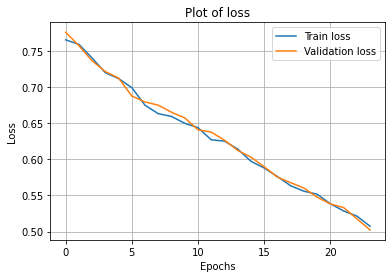

In [ ]:
def loss_plt(train_l, valid_l):
  xs = np.arange(0,len(train_l))
  fig, ax = plt.subplots()
  ax.plot(xs, train_l, label = "Train loss")
  ax.plot(xs, valid_l, label = "Validation loss")
  ax.set(xlabel='Epochs', ylabel='Loss',
        title='Plot of loss')
  ax.legend()
  ax.grid()
  plt.show()

**To little data**

In [112]:
VALIDATION_SET = 13
"""
x_train, x_valid, y_train, y_valid = train_test_split(train_grayscales, labels_imgs, test_size=VALIDATION_SET,
                                                    shuffle=True,random_state=42)
"""
x_train, x_valid, y_train, y_valid = train_test_split(train_green_channel, labels_imgs, test_size=VALIDATION_SET)


print('Shape of traning data tensor:',x_train.shape)
print('Length of training label vector:',len(y_train))
print('Shape of validation data tensor:',x_valid.shape)
print('Length of validation label vector:',len(y_valid))
#print('Shape of test data tensor:',x_test.shape)
#print('Length of validation label vector:',len(y_test))
# Using pytouch data loaders

BATCH_SIZE = 2

print('Train: ',end="")
train_dataset = TensorDataset(torch.from_numpy(x_train).unsqueeze(1), torch.from_numpy(y_train).unsqueeze(1))

train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,
                         shuffle=True,num_workers=2)

print(len(train_loader),'images')

print('Validation: ',end="")
validation_dataset = TensorDataset(torch.from_numpy(x_valid).unsqueeze(1), torch.from_numpy(y_valid).unsqueeze(1))

validation_loader =DataLoader(validation_dataset,batch_size=VALIDATION_SET,
                         shuffle=True,num_workers=2)

print(len(validation_dataset),'images')


Shape of traning data tensor: (2, 584, 565)
Length of training label vector: 2
Shape of validation data tensor: (13, 584, 565)
Length of validation label vector: 13
Train: 1 images
Validation: 13 images


In [117]:

model_to_little = UNet().to(device)
#print(model)
optimizer = optim.Adam(model_to_little.parameters(),lr=0.01)
#criterion = nn.BCEWithLogitsLoss()
criterion = diceloss()
epochs = 100
train_loss_little = []
val_loss_little  = []
for epoch in range(1,epochs+1):
    train_loss_little.append(train(model_to_little, train_loader, epoch))
    with torch.no_grad():
        print('\nValidtionset:')
        val_loss_little.append(evaluate(model_to_little, validation_loader,epoch))
""""""

Train loss.item() = 0.7526213526725769
Train Epoch: 1, Loss: 0.752621

Validtionset:
Valdiation loss.item() = 0.740909218788147
Train loss.item() = 0.7331063151359558
Train Epoch: 2, Loss: 0.733106

Validtionset:
Valdiation loss.item() = 0.7166671752929688
Train loss.item() = 0.7091281414031982
Train Epoch: 3, Loss: 0.709128

Validtionset:
Valdiation loss.item() = 0.6978783011436462
Train loss.item() = 0.6903610229492188
Train Epoch: 4, Loss: 0.690361

Validtionset:
Valdiation loss.item() = 0.690210223197937
Train loss.item() = 0.6836763024330139
Train Epoch: 5, Loss: 0.683676

Validtionset:
Valdiation loss.item() = 0.6848758459091187
Train loss.item() = 0.6786319017410278
Train Epoch: 6, Loss: 0.678632

Validtionset:
Valdiation loss.item() = 0.6798064708709717
Train loss.item() = 0.6730295419692993
Train Epoch: 7, Loss: 0.673030

Validtionset:
Valdiation loss.item() = 0.6737537384033203
Train loss.item() = 0.665459156036377
Train Epoch: 8, Loss: 0.665459

Validtionset:
Valdiation loss

''

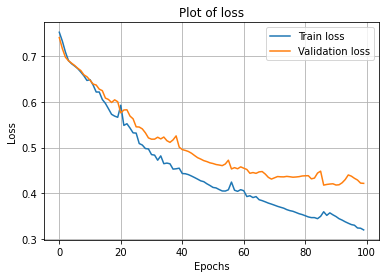

In [118]:
loss_plt(train_loss_little,val_loss_little)

In [ ]:
test = torch.from_numpy(test_imgs_green_channel).unsqueeze(1)
test = test.to(device)
out = model(test.float())

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (18, 30))
ax[0].imshow(out[0,0].cpu().detach().numpy()) 
ax[1].imshow(x_valid[1]) 
plt.show()

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 3, 1)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        print(conv1.shape)
        print(upconv2.shape)
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1) 
                            )
        return expand

In [ ]:
"""

model = UNET(1,2).to(device)
#print(model)
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
criterion = nn.BCEWithLogitsLoss()
epochs = 20
train_loss = []
val_loss = []
for epoch in range(1,epochs+1):
    train(epoch)
    with torch.no_grad():
        print('\nValidtionset:')
        evaluate(validation_loader,epoch)
"""


In [ ]:
import time
def train__(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                x = torch.transpose(x.float(),0,1)
                y = y.cuda()
                y = torch.transpose(y.float(),0,1)
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 10 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [ ]:
"""
model = UNET(1,1).to(device)
#print(model)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
_,_ = train(model, train_loader, validation_loader, loss_fn, optimizer, acc_metric, epochs=20) 
"""
